# The JPEG-LS/LOCO-I Lossless Image Compression Algorithm

# Read Image and store it's RGB values

In [1]:
import jpeg_ls
import imageio as iio
from functools import reduce
import numpy as np
import math
from IPython.display import Image, display
import zlib

# img is in RGBA format , opacity 0 for png images
img = iio.imread("./images/earth.png", format='png')

# get grayscale values for each color
red_img = [[pixel[0] for pixel in row] for row in img]
green_img = [[pixel[1] for pixel in row] for row in img]
blue_img = [[pixel[2] for pixel in row] for row in img]

width = len(red_img[0])
height = len(red_img)

M = 256  # alphabet set

# Encode each monochromatic grayscale part

In [2]:
# JPEG-LS encoding

encode_red_jpeg = jpeg_ls.jpegls_encode(red_img, M)
encode_green_jpeg = jpeg_ls.jpegls_encode(green_img, M)
encode_blue_jpeg = jpeg_ls.jpegls_encode(blue_img, M)

# PNG encoding

encode_red_png = [zlib.compress(bytearray(row), level=-1) for row in red_img]
encode_green_png = [zlib.compress(bytearray(row), level=-1) for row in green_img]
encode_blue_png = [zlib.compress(bytearray(row), level=-1) for row in blue_img]

# Compare the size before and after compression for:
### 1. RGB Image
### 2. JPEG Encoded File
### 3. PNG Encoded File

In [3]:
len_red_jpeg = reduce(lambda x, y: x + reduce(lambda a, b: a + len(b), y, 0), encode_red_jpeg, 0)
len_green_jpeg = reduce(lambda x, y: x + reduce(lambda a, b: a + len(b), y, 0), encode_green_jpeg, 0)
len_blue_jpeg = reduce(lambda x, y: x + reduce(lambda a, b: a + len(b), y, 0), encode_blue_jpeg, 0)

len_red_png = reduce(lambda x, y: x + reduce(lambda a, b: a + len(bin(b)[2:]), y, 0), encode_red_png, 0)
len_green_png = reduce(lambda x, y: x + reduce(lambda a, b: a + len(bin(b)[2:]), y, 0), encode_red_png, 0)
len_blue_png = reduce(lambda x, y: x + reduce(lambda a, b: a + len(bin(b)[2:]), y, 0), encode_red_png, 0)


# Original size of image
# 8-bits/pixel color
print("original length", 3 * 8 * width * height // 1024, 'kB')

# Size of image after compressing (via JPEG-LS)
print("compressed length in jpeg", (len_red_jpeg + len_green_jpeg + len_blue_jpeg) // 1024, 'kB')

# size of image after compressing (via PNG encoded file)
print("compressed length in png", (len_red_png + len_green_png + len_blue_png) // 1024, 'kB')

original length 13824 kB
compressed length in jpeg 5120 kB
compressed length in png 6137 kB


# Decompress each encoded file

In [4]:
# decompression step (JPEG-LS)

decoded_red_jpeg = jpeg_ls.jpegls_decode(encode_red_jpeg, M)
decoded_green_jpeg = jpeg_ls.jpegls_decode(encode_green_jpeg, M)
decoded_blue_jpeg = jpeg_ls.jpegls_decode(encode_blue_jpeg, M)

image_matrix_jpeg = [[(r, g, b) for r, g, b in zip(row_red, row_green, row_blue)]
                for row_red, row_green, row_blue in zip(decoded_red_jpeg, decoded_green_jpeg, decoded_blue_jpeg)]


# decompression step (PNG)

decoded_red_png = [zlib.decompress(row) for row in encode_red_png]
decoded_green_png = [zlib.decompress(row) for row in encode_green_png]
decoded_blue_png = [zlib.decompress(row) for row in encode_blue_png]

image_matrix_png = [[(r, g, b) for r, g, b in zip(row_red, row_green, row_blue)]
                    for row_red, row_green, row_blue in zip(decoded_red_png, decoded_green_png, decoded_blue_png)]


# Write new image onto the disk

newimg_jpegls = iio.imwrite('./images/earth_compressedjpeg.jpeg', np.uint8(image_matrix_jpeg))
newimg_png = iio.imwrite('./images/earth_compressedpng.png', np.uint8(image_matrix_png))

# Comparison of original vs compressed image 

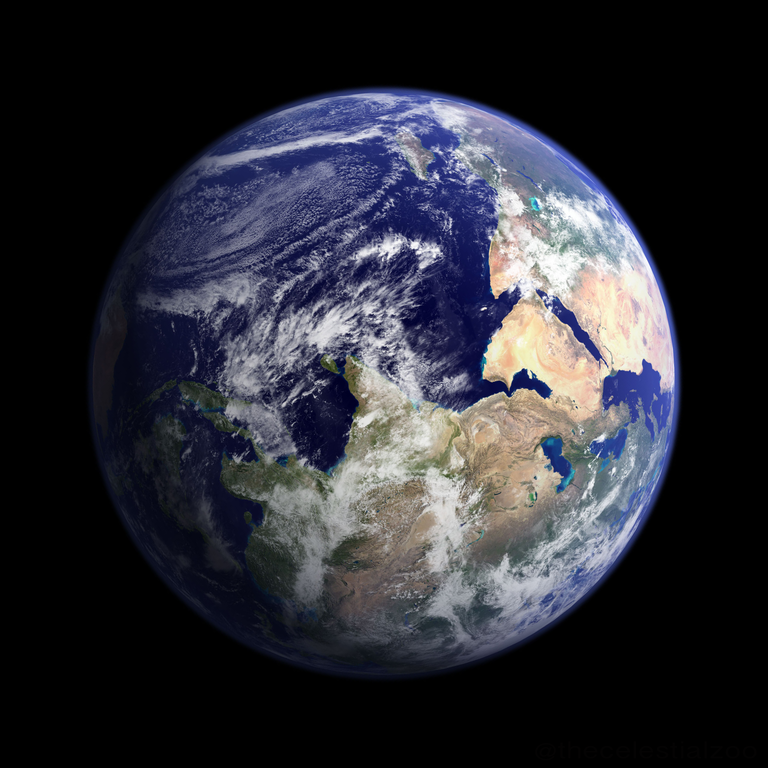

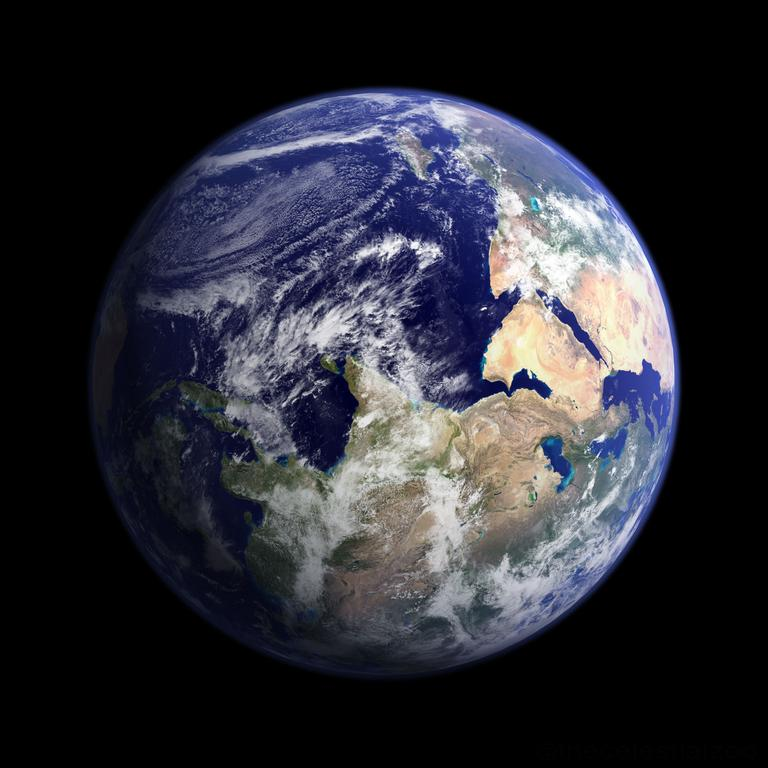

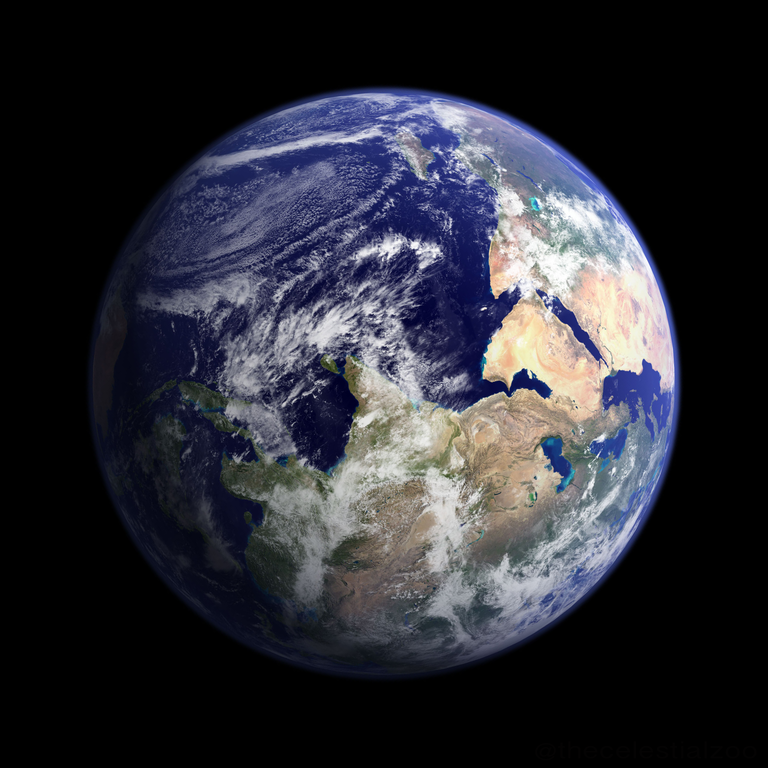

In [5]:
display(Image(filename="./images/earth.png"))
display(Image(filename="./images/earth_compressedjpeg.jpeg"))
display(Image(filename="./images/earth_compressedpng.png"))

# Computing the Peak-Signal-To-Noise-Ratio (PSNR) Values
PSNR is most easily defined via the mean squared error (MSE). Given a noise-free m×n monochrome image I and its noisy approximation K, MSE is defined as

${\displaystyle {\mathit {MSE}}={\frac {1}{m\,n}}\sum _{i=0}^{m-1}\sum _{j=0}^{n-1}[I(i,j)-K(i,j)]^{2}.}$
The PSNR (in dB) is defined as

${\displaystyle {\begin{aligned}{\mathit {PSNR}}&=10\cdot \log _{10}\left({\frac {{\mathit {MAX}}_{I}^{2}}{\mathit {MSE}}}\right)\\&=20\cdot \log _{10}\left({\frac {{\mathit {MAX}}_{I}}{\sqrt {\mathit {MSE}}}}\right)\\&=20\cdot \log _{10}({\mathit {MAX}}_{I})-10\cdot \log _{10}({\mathit {MSE}}).\end{aligned}}}$

Here, MAXI is the maximum possible pixel value of the image. When the pixels are represented using 8 bits per sample, this is 255. More generally, when samples are represented using linear PCM with B bits per sample, MAXI is 2B − 1.


### Application in color images

For color images with three RGB values per pixel, the definition of PSNR is the same except that the MSE is the sum over all squared value differences (now for each color, i.e. three times as many differences as in a monochrome image) divided by image size and by three.

In [6]:
# PSNR value for LPEG-LS

MSE_jpeg = 0.0
size = width * height
for i in range(height):
    for j in range(width):
        MSE_jpeg += ((red_img[i][j] - decoded_red_jpeg[i][j]) ** 2)

for i in range(height):
    for j in range(width):
        MSE_jpeg += ((green_img[i][j] - decoded_green_jpeg[i][j]) ** 2)

for i in range(height):
    for j in range(width):
        MSE_jpeg += ((blue_img[i][j] - decoded_blue_jpeg[i][j]) ** 2)

MSE_jpeg = MSE_jpeg / (3 * size)
print("Mean Squared Error In JPEG-LS" ,MSE_jpeg)

# Since JPEG-LS/LOCO-I is lossless , we expect it to be 0.0 which is the case

MSE_png = 0.0
for i in range(height):
    for j in range(width):
        MSE_png += ((red_img[i][j] - decoded_red_png[i][j]) ** 2)

for i in range(height):
    for j in range(width):
        MSE_png += ((green_img[i][j] - decoded_green_png[i][j]) ** 2)

for i in range(height):
    for j in range(width):
        MSE_png += ((blue_img[i][j] - decoded_blue_png[i][j]) ** 2)

MSE_png = MSE_png / (3 * size)
print("Mean Squared Error In PNG" ,MSE_png)

# Since PNG is lossless , we expect it to be 0.0 which is the case

# print("PSNR for JPEG-LS ", 20 * math.log10(255/math.sqrt(MSE)))

Mean Squared Error In JPEG-LS 0.0
Mean Squared Error In PNG 0.0
